In [54]:
import cv2
import os
from datetime import datetime
import time
import torch
import numpy as np
import math
from pathlib import Path
import csv
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt


# helper to ensure directory
def ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)


In [ ]:
import serial
import time
import threading
import cv2
import os
import shutil
from pathlib import Path
from datetime import datetime

# ---------------- MOTOR ----------------
puerto = "/dev/ttyUSB0"  # ESP32
baudrate = 115200

def ejecutar_motor():
    try:
        esp = serial.Serial(puerto, baudrate, timeout=1)
        time.sleep(2)  # esperar reinicio
        print("Conectado al ESP32 en", puerto)
    except Exception as e:
        print("Error al conectar:", e)
        return

    # Enviar comando para activar motor
    esp.write(b"motor\n")
    print("Comando 'motor' enviado al ESP32.")

    # Leer la respuesta del ESP32
    while True:
        if esp.in_waiting:
            try:
                respuesta = esp.readline().decode('utf-8', errors='ignore').strip()
                if respuesta:
                    print(respuesta)
                    if "Motor terminado" in respuesta:
                        break
            except Exception as e:
                print("Error leyendo Serial:", e)
        else:
            time.sleep(0.1)

    esp.close()
    print("Puerto serial cerrado.")

# ---------------- CÁMARA ----------------
CAPTURE_COUNT = 20  # número de imágenes a capturar
INTERVAL = 1        # segundos entre capturas
MODEL_FOLDER = Path('.')            
MODEL_FILE_NAME = 'best_model.pth'      
MODEL_PATH = (MODEL_FOLDER / MODEL_FILE_NAME).resolve()
if not MODEL_PATH.exists():
    raise FileNotFoundError(f'No se encontró el archivo del modelo en {MODEL_PATH}. Ajusta MODEL_FILE_NAME o mueve el archivo junto al notebook.')

MODEL_LOAD_PATH = MODEL_PATH
if MODEL_PATH.suffix == '.pth':
    MODEL_LOAD_PATH = MODEL_PATH.with_suffix('.pt')
    if not MODEL_LOAD_PATH.exists() or MODEL_LOAD_PATH.stat().st_mtime < MODEL_PATH.stat().st_mtime:
        shutil.copyfile(MODEL_PATH, MODEL_LOAD_PATH)
        print('Copiando archivo .pth a .pt para compatibilidad con Ultralytics ->', MODEL_LOAD_PATH.name)
else:
    print('El archivo ya posee extensión compatible (.pt).')
print('Usando exclusivamente el modelo:', MODEL_PATH.name)
print('Ruta efectiva para cargar en Ultralytics:', MODEL_LOAD_PATH)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def capturar_imagenes():
    # Crear carpeta timestamp
    global carpeta 
    carpeta = datetime.now().strftime('%Y%m%d_%H%M%S')
    ensure_dir(carpeta)

    # Abrir cámara
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError('No se pudo abrir la cámara. Verifica que tienes una cámara conectada y permisos.')

    for i in range(CAPTURE_COUNT):
        ret, frame = cap.read()
        if ret:
            nombre_archivo = os.path.join(carpeta, f'imagen_{i+1}.jpg')
            cv2.imwrite(nombre_archivo, frame)
            print(f'Imagen {i+1}/{CAPTURE_COUNT} guardada -> {nombre_archivo}')
        else:
            print(f'Frame {i+1} no leído')
        time.sleep(INTERVAL)

    cap.release()
    cv2.destroyAllWindows()
    print(f'Proceso completado. Imágenes guardadas en: {carpeta}')

# ---------------- EJECUCIÓN CONCURRENTE ----------------
# Crear hilos
hilo_motor = threading.Thread(target=ejecutar_motor)
hilo_camara = threading.Thread(target=capturar_imagenes)

# Iniciar hilos
hilo_motor.start()
hilo_camara.start()

# Esperar que ambos terminen
hilo_motor.join()
hilo_camara.join()

print("Motor y captura de imágenes completados.")

In [ ]:
# --- Cargar el modelo YOLO (solo archivo local ya verificado) ---
backend = None
model = None
model_path = MODEL_LOAD_PATH
print('Intentando cargar el archivo:', model_path)

# 1) Intento con Ultralytics YOLOv8/YOLO11 (misma librería)
forced_ultra_task = None
try:
    from ultralytics import YOLO
    print('Cargando modelo local con ultralytics.YOLO...')
    model = YOLO(str(model_path))
    backend = 'ultralytics'
    if getattr(model, 'task', None) != 'classify':
        try:
            model.task = 'classify'
            if hasattr(model, 'overrides'):
                model.overrides['task'] = 'classify'
            forced_ultra_task = 'classify'
            print('Forzando modo de tarea a "classify" para este modelo.')
        except Exception as set_task_err:
            print('No se pudo establecer el modo classify automáticamente:', set_task_err)
except Exception as e_ultra:
    print('ultralytics no disponible o carga falló:', e_ultra)

# 2) Intento con torch.hub (YOLOv5 custom). Descarga el repo la primera vez.
if model is None:
    try:
        print('Intentando torch.hub (ultralytics/yolov5 custom)...')
        model = torch.hub.load('ultralytics/yolov5', 'custom', path=str(model_path), trust_repo=True, source='github', force_reload=False)
        backend = 'yolov5_hub'
    except Exception as e_hub:
        print('torch.hub tampoco pudo cargar el modelo:', e_hub)

# 3) Intento manual: cargar checkpoint como módulo PyTorch
if model is None:
    try:
        print('Intentando carga manual con torch.load...')
        checkpoint = torch.load(str(model_path), map_location='cpu')
        if isinstance(checkpoint, torch.nn.Module):
            model = checkpoint
            backend = 'torch_module'
        elif isinstance(checkpoint, dict) and 'model' in checkpoint:
            model = checkpoint['model']
            backend = 'torch_state_dict'
        else:
            raise RuntimeError('Formato del checkpoint no reconocido.')
    except Exception as e_manual:
        raise RuntimeError('No se pudo cargar el modelo local. Instala "ultralytics" o exporta el .pt a un formato compatible.') from e_manual

if backend == 'ultralytics':
    current_task = getattr(model, 'task', None)
    if current_task != 'classify' and forced_ultra_task is None:
        print('Advertencia: Ultralytics asumió tarea', current_task, '. Si tu modelo es de clasificación, considera ajustar forced_ultra_task.')
elif backend is None:
    raise RuntimeError('No fue posible inicializar ningún backend con el modelo proporcionado.')

print('Modelo cargado desde archivo local. Backend:', backend)

Intentando cargar el archivo: /home/starkiller/Documentos/8smestre/ia/detector/best_model.pth
Cargando modelo local con ultralytics.YOLO...
WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Modelo cargado desde archivo local. Backend: ultralytics
Modelo cargado desde archivo local. Backend: ultralytics


In [ ]:
# --- Predecir sobre las imágenes capturadas ---
results_list = []
image_paths = sorted([str(p) for p in Path(carpeta).glob('*.jpg')])
print('Imágenes encontradas:', image_paths)
for img_path in image_paths:
    print('Procesando:', img_path)
    try:
        if backend == 'ultralytics':
            res = model(img_path)[0]  # objeto Results de ultralytics
            boxes = getattr(res, 'boxes', None)
            prediction_taken = False
            if boxes is not None and len(boxes) > 0:
                confidences = boxes.conf.tolist()
                classes = boxes.cls.tolist()
                top_idx = int(np.argmax(confidences))
                top_conf = float(confidences[top_idx])
                top_cls = int(classes[top_idx])
                names = getattr(model, 'names', {}) if hasattr(model, 'names') else {}
                top_name = names.get(top_cls, str(top_cls))
                prediction_taken = True
            else:
                probs = getattr(res, 'probs', None)
                if probs is not None:
                    top_idx = None
                    top_conf = 0.0
                    if hasattr(probs, 'top1') and hasattr(probs, 'top1conf'):
                        top_idx = int(probs.top1)
                        top_conf = float(probs.top1conf)
                    else:
                        prob_values = None
                        if isinstance(probs, torch.Tensor):
                            prob_values = probs
                        elif hasattr(probs, 'data'):
                            prob_values = probs.data
                        elif isinstance(probs, np.ndarray):
                            prob_values = probs
                        if prob_values is not None:
                            prob_np = prob_values.detach().cpu().numpy() if hasattr(prob_values, 'detach') else np.array(prob_values)
                            top_idx = int(np.argmax(prob_np))
                            top_conf = float(prob_np[top_idx])
                    if top_idx is not None:
                        names = getattr(model, 'names', {}) if hasattr(model, 'names') else {}
                        top_name = names.get(top_idx, str(top_idx))
                        prediction_taken = True
                        print('   (clasificación por probs)')
            if prediction_taken:
                results_list.append({'image': img_path, 'class': top_name, 'conf': top_conf})
                print(f' -> {top_name} ({top_conf:.3f})')
            else:
                results_list.append({'image': img_path, 'class': None, 'conf': 0.0})
                print(' -> Sin detecciones en esta imagen.')
        elif backend in {'torch_module','torch_state_dict'}:
            model.eval()
            img = cv2.imread(img_path)
            if img is None:
                raise RuntimeError('No se pudo leer la imagen para inferencia.')
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            tensor = torch.from_numpy(img_rgb).float().permute(2,0,1).unsqueeze(0) / 255.0
            with torch.no_grad():
                raw = model(tensor)
            # Suponemos salida estilo YOLO (bs, anchors, (5 + num_cls))
            if isinstance(raw, (list, tuple)) and len(raw) > 0:
                raw = raw[0]
            if hasattr(raw, 'dim') and raw.dim() == 4:
                raw = raw[0]
            raw = raw.cpu().numpy().reshape(-1, raw.shape[-1])
            boxes = raw[:, :4]
            obj_conf = raw[:, 4]
            class_scores = raw[:, 5:]
            scores = obj_conf[:, None] * class_scores
            top_idx = int(np.argmax(scores))
            top_conf = float(np.max(scores))
            top_cls = int(np.argmax(class_scores[top_idx]))
            names = getattr(model, 'names', {}) if hasattr(model, 'names') else {}
            top_name = names.get(top_cls, str(top_cls))
            results_list.append({'image': img_path, 'class': top_name, 'conf': top_conf})
            print(f' -> {top_name} ({top_conf:.3f})')
        else:
            raise RuntimeError('Backend no soportado para predicción.')
    except Exception as e:
        print('Error procesando', img_path, e)
        results_list.append({'image': img_path, 'class': None, 'conf': 0.0})
print('Predicción completada sobre todas las imágenes.')

Imágenes encontradas: ['20251126_203134/imagen_1.jpg', '20251126_203134/imagen_10.jpg', '20251126_203134/imagen_11.jpg', '20251126_203134/imagen_12.jpg', '20251126_203134/imagen_13.jpg', '20251126_203134/imagen_14.jpg', '20251126_203134/imagen_15.jpg', '20251126_203134/imagen_16.jpg', '20251126_203134/imagen_17.jpg', '20251126_203134/imagen_18.jpg', '20251126_203134/imagen_19.jpg', '20251126_203134/imagen_2.jpg', '20251126_203134/imagen_20.jpg', '20251126_203134/imagen_3.jpg', '20251126_203134/imagen_4.jpg', '20251126_203134/imagen_5.jpg', '20251126_203134/imagen_6.jpg', '20251126_203134/imagen_7.jpg', '20251126_203134/imagen_8.jpg', '20251126_203134/imagen_9.jpg']
Procesando: 20251126_203134/imagen_1.jpg
Error procesando 20251126_203134/imagen_1.jpg /home/starkiller/Documentos/8smestre/ia/detector/best_model.pth acceptable suffix is {'.pt'}, not .pth
Procesando: 20251126_203134/imagen_10.jpg

Ultralytics 8.3.230 🚀 Python-3.10.19 torch-2.9.1+cu128 CPU (AMD Ryzen 5 5500U with Radeon Gra

In [ ]:
# --- Agregación y cálculo de índices ---
import pandas as pd
from collections import Counter
import json

confs = [r['conf'] for r in results_list]
classes = [r['class'] or 'None' for r in results_list]

# Media aritmética
arith_mean = float(np.mean(confs)) if len(confs) > 0 else 0.0
# Media geométrica (evitar ceros con eps)
eps = 1e-9
geom_mean = float(np.exp(np.mean(np.log(np.array(confs) + eps)))) if len(confs) > 0 else 0.0

# Determinar clase final: la que tenga mayor promedio de confianza entre las imágenes donde aparece
class_scores = {}
for r in results_list:
    cls = r['class'] or 'None'
    class_scores.setdefault(cls, []).append(r['conf'])
avg_class_scores = {k: (sum(v) / len(v) if len(v) > 0 else 0.0) for k, v in class_scores.items()}
final_class = max(avg_class_scores.items(), key=lambda x: x[1])[0] if len(avg_class_scores) > 0 else None
final_conf = avg_class_scores.get(final_class, 0.0) if final_class is not None else 0.0

print('Resumen por imagen:')
for r in results_list:
    print(f"{Path(r['image']).name}: {r['class']} ({r['conf']:.3f})")

print('\nPromedios sobre las {} imágenes:'.format(len(confs)))
print(f'Arithmetic mean confidence: {arith_mean:.4f}')
print(f'Geometric mean confidence: {geom_mean:.4f}')
print(f'Final class (mayor avg confidence): {final_class} with {final_conf:.4f}')

# Crear DataFrame para análisis posterior
results_df = pd.DataFrame(results_list)
if not results_df.empty:
    results_df['image_name'] = results_df['image'].apply(lambda p: Path(p).name)
else:
    results_df['image_name'] = []

# Guardar resultados en CSV dentro de la carpeta de la captura
csv_path = Path(carpeta) / 'results.csv'
results_df.to_csv(csv_path, index=False)
print('Resultados guardados en', csv_path)

# Guardar resumen adicional en JSON
summary_payload = {
    'capture_folder': carpeta,
    'image_count': len(results_list),
    'final_class': final_class,
    'final_confidence': final_conf,
    'arithmetic_mean': arith_mean,
    'geometric_mean': geom_mean,
    'class_scores': avg_class_scores,
}
json_path = Path(carpeta) / 'results_summary.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(summary_payload, f, ensure_ascii=False, indent=2)
print('Resumen JSON guardado en', json_path)

Resumen por imagen:
imagen_1.jpg: None (0.000)
imagen_10.jpg: None (0.000)
imagen_11.jpg: None (0.000)
imagen_12.jpg: None (0.000)
imagen_13.jpg: None (0.000)
imagen_14.jpg: None (0.000)
imagen_15.jpg: None (0.000)
imagen_16.jpg: None (0.000)
imagen_17.jpg: None (0.000)
imagen_18.jpg: None (0.000)
imagen_19.jpg: None (0.000)
imagen_2.jpg: None (0.000)
imagen_20.jpg: None (0.000)
imagen_3.jpg: None (0.000)
imagen_4.jpg: None (0.000)
imagen_5.jpg: None (0.000)
imagen_6.jpg: None (0.000)
imagen_7.jpg: None (0.000)
imagen_8.jpg: None (0.000)
imagen_9.jpg: None (0.000)

Promedios sobre las 20 imágenes:
Arithmetic mean confidence: 0.0000
Geometric mean confidence: 0.0000
Final class (mayor avg confidence): None with 0.0000
Resultados guardados en 20251126_203134/results.csv
Resumen JSON guardado en 20251126_203134/results_summary.json
Resultados guardados en 20251126_203134/results.csv
Resumen JSON guardado en 20251126_203134/results_summary.json


In [ ]:
# --- Visualizar tabla de resultados ---
if 'results_df' not in globals():
    raise RuntimeError('Debes ejecutar las celdas anteriores para generar results_df.')
display(results_df[['image_name','class','conf']])
print('Totales por clase detectada:')
print(results_df['class'].value_counts(dropna=False))

,image_name,class,conf
0,imagen_1.jpg,None,0.0
1,imagen_10.jpg,None,0.0
2,imagen_11.jpg,None,0.0
3,imagen_12.jpg,None,0.0
4,imagen_13.jpg,None,0.0
5,imagen_14.jpg,None,0.0
6,imagen_15.jpg,None,0.0
7,imagen_16.jpg,None,0.0
8,imagen_17.jpg,None,0.0
9,imagen_18.jpg,None,0.0


Totales por clase detectada:
class
None    20
Name: count, dtype: int64


In [ ]:
# --- Filtrar detecciones con confianza mínima ---
CONF_THRESHOLD = 0.25
if results_df.empty:
    high_conf = results_df
else:
    high_conf = results_df[results_df['conf'] >= CONF_THRESHOLD].copy()
print(f'Detecciones con conf >= {CONF_THRESHOLD}: {len(high_conf)}')
display(high_conf[['image_name','class','conf']])

Detecciones con conf >= 0.25: 0


,image_name,class,conf


In [ ]:
# --- Estadísticas por clase ---
if results_df.empty:
    print('No hay predicciones para analizar.')
else:
    class_summary = (
        results_df.groupby('class')['conf']
        .agg(['count','mean','max','min'])
        .rename(columns={'count':'detections','mean':'avg_conf','max':'max_conf','min':'min_conf'})
        .sort_values('avg_conf', ascending=False)
    )
    display(class_summary)

,detections,avg_conf,max_conf,min_conf
class,,,,


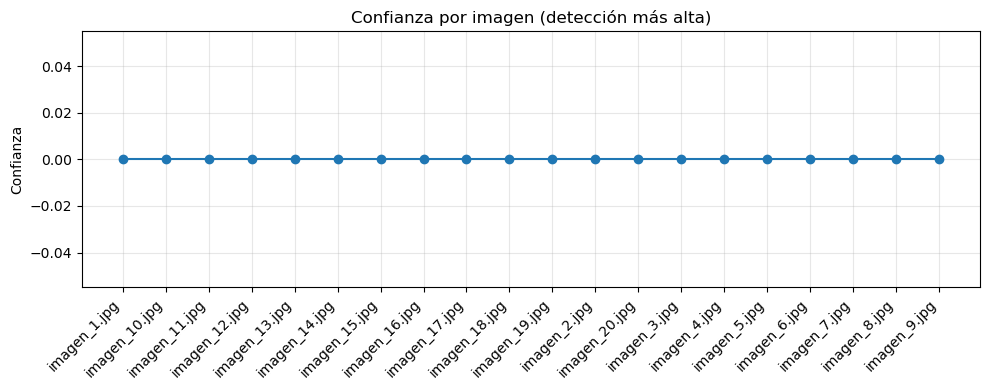

In [ ]:
# --- Visualización rápida de las confianzas ---
if results_df.empty:
    print('No hay datos para graficar.')
else:
    plt.figure(figsize=(10,4))
    plt.plot(results_df['image_name'], results_df['conf'], marker='o')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Confianza')
    plt.title('Confianza por imagen (detección más alta)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# --- Función opcional para generar imágenes anotadas ---
def generar_anotaciones(origenes, destino=None):
    if destino is None:
        destino = Path(carpeta) / 'anotadas'
    destino = Path(destino)
    ensure_dir(destino)
    for img_path in origenes:
        try:
            if backend == 'ultralytics':
                res = model(img_path)[0]
                annotated = res.plot()
            else:
                res = model(img_path)
                res.render()
                annotated = res.ims[0]
            salida = destino / f"annotated_{Path(img_path).name}"
            # OpenCV espera BGR
            cv2.imwrite(str(salida), annotated if backend == 'yolov5_hub' else cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
            print('Guardada anotación en', salida)
        except Exception as e:
            print('No fue posible anotar', img_path, '->', e)
    return destino

In [ ]:
# --- Ejecutar anotaciones y previsualizar una imagen ---
if len(image_paths) == 0:
    print('No hay imágenes para anotar.')
else:
    anotadas_dir = generar_anotaciones(image_paths)
    muestra = sorted(anotadas_dir.glob('annotated_*.jpg'))
    if muestra:
        ejemplo = muestra[0]
        img = cv2.cvtColor(cv2.imread(str(ejemplo)), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Ejemplo anotado: {ejemplo.name}')
        plt.show()
    else:
        print('No se generaron imágenes anotadas.')


Ultralytics 8.3.230 🚀 Python-3.10.19 torch-2.9.1+cu128 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
No fue posible anotar 20251126_203134/imagen_1.jpg -> /home/starkiller/Documentos/8smestre/ia/detector/best_model.pth acceptable suffix is {'.pt'}, not .pth

Ultralytics 8.3.230 🚀 Python-3.10.19 torch-2.9.1+cu128 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
No fue posible anotar 20251126_203134/imagen_10.jpg -> /home/starkiller/Documentos/8smestre/ia/detector/best_model.pth acceptable suffix is {'.pt'}, not .pth

Ultralytics 8.3.230 🚀 Python-3.10.19 torch-2.9.1+cu128 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
No fue posible anotar 20251126_203134/imagen_11.jpg -> /home/starkiller/Documentos/8smestre/ia/detector/best_model.pth acceptable suffix is {'.pt'}, not .pth

Ultralytics 8.3.230 🚀 Python-3.10.19 torch-2.9.1+cu128 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
Ultralytics 8.3.230 🚀 Python-3.10.19 torch-2.9.1+cu128 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
No fue posible anotar 2

In [ ]:
# --- Alternativa de decisión final (mayoría simple) ---
if results_df.empty:
    print('No hay datos para calcular mayoría.')
else:
    conteo = Counter(results_df['class'].fillna('None'))
    mayor_clase, mayor_val = conteo.most_common(1)[0]
    print('Clase más frecuente:', mayor_clase, 'con', mayor_val, 'apariciones de', len(results_df))
    print('Distribución completa:')
    for clase, total in conteo.items():
        print(f' - {clase}: {total}')

Clase más frecuente: None con 20 apariciones de 20
Distribución completa:
 - None: 20


In [ ]:
# --- Limpieza opcional de carpetas antiguas ---
import shutil

def limpiar_capturas_antiguas(base_path='.', conservar=3):
    base = Path(base_path)
    capturas = sorted([p for p in base.glob('20????????_??????') if p.is_dir()])
    excedente = len(capturas) - conservar
    if excedente <= 0:
        print('No hay carpetas para eliminar.')
        return
    for carpeta_antigua in capturas[:excedente]:
        try:
            shutil.rmtree(carpeta_antigua)
            print('Carpeta eliminada:', carpeta_antigua)
        except Exception as e:
            print('No se pudo eliminar', carpeta_antigua, '->', e)

In [ ]:
# --- Prueba rápida de cámara ---
def probar_camara(index=0):
    prueba = cv2.VideoCapture(index)
    if not prueba.isOpened():
        print('No se pudo abrir la cámara', index)
        return False
    ret, frame = prueba.read()
    prueba.release()
    if not ret:
        print('La cámara se abrió pero no entregó frames.')
        return False
    print('Cámara', index, 'operativa. Resolución:', frame.shape[1], 'x', frame.shape[0])
    return True

In [ ]:
# --- Identificar cámaras conectadas ---
def listar_camaras(max_indices=5):
    disponibles = []
    for idx in range(max_indices):
        cap = cv2.VideoCapture(idx)
        if cap.isOpened():
            ret, _ = cap.read()
            if ret:
                disponibles.append(idx)
                print(f"Cámara {idx}: DISPONIBLE")
            else:
                print(f"Cámara {idx}: abierta pero no entrega frames")
        else:
            print(f"Cámara {idx}: no disponible")
        cap.release()
    if not disponibles:
        print("No se detectaron cámaras operativas en los primeros", max_indices, "indices.")
    else:
        print("Índices utilizables:", disponibles)

# Ejecuta la función para ver las cámaras conectadas
listar_camaras(max_indices=6)


Cámara 0: DISPONIBLE
Cámara 1: no disponible


[ WARN:1@720.330] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video1): can't open camera by index


Cámara 2: DISPONIBLE
Cámara 3: no disponible
Cámara 4: no disponible
Cámara 5: no disponible
Índices utilizables: [0, 2]


[ WARN:1@720.942] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ WARN:1@720.942] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video4): can't open camera by index
[ WARN:1@720.942] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video5): can't open camera by index


In [ ]:
# --- Conexión serial y envío de estados al ESP32 ---
# Funciones para listar puertos, seleccionar uno y enviar los estados: 'sana', 'danada', 'defectosa'
try:
    import serial
    import serial.tools.list_ports as list_ports
except ImportError:
    import sys, subprocess
    print('pyserial no instalado. Instalando pyserial...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pyserial'])
    import serial
    import serial.tools.list_ports as list_ports
import time

VALID_STATES = ("sana", "danada", "defectosa")


def listar_puertos():
    """Devuelve lista de puertos serial disponibles y los imprime."""
    ports = list(list_ports.comports())
    dispositivos = []
    if not ports:
        print("No se encontraron puertos serie disponibles.")
        return dispositivos
    for i, p in enumerate(ports):
        print(f"{i}: {p.device} - {p.description}")
        dispositivos.append(p.device)
    return dispositivos


def seleccionar_puerto(preferido: str = None):
    """Selecciona un puerto. Si 'preferido' está presente, lo devuelve; si no, devuelve el primero encontrado."""
    puertos = listar_puertos()
    if not puertos:
        return None
    if preferido and preferido in puertos:
        print(f"Usando puerto preferido: {preferido}")
        return preferido
    if len(puertos) == 1:
        print(f"Seleccionado puerto: {puertos[0]}")
        return puertos[0]
    print(f"Varios puertos disponibles, se selecciona por defecto: {puertos[0]}\nPara usar otro, llama seleccionar_puerto('/dev/ttyUSB1')")
    return puertos[0]


def send_state(port: str, state: str, baud: int = 115200, timeout: float = 1.0):
    """Envía un estado por serial y lee una respuesta opcional.

    Args:
        port: ruta del puerto (por ejemplo '/dev/ttyUSB0')
        state: uno de VALID_STATES
        baud: velocidad en baudios
        timeout: tiempo de espera en segundos

    Returns:
        La respuesta leída (string) o None si no hay respuesta.
    """
    if state not in VALID_STATES:
        raise ValueError(f"Estado inválido: {state}. Usa uno de: {VALID_STATES}")
    if port is None:
        raise RuntimeError("Puerto no especificado. Usa seleccionar_puerto() para obtener uno.")

    try:
        ser = serial.Serial(port, baudrate=baud, timeout=timeout)
    except Exception as e:
        raise RuntimeError(f"No se pudo abrir el puerto {port}: {e}") from e

    try:
        # Dar tiempo para que el dispositivo se estabilice
        time.sleep(0.1)
        payload = (state + "\n").encode()
        ser.write(payload)
        # Intentar leer una línea de respuesta (si el ESP32 responde)
        try:
            resp = ser.readline().decode(errors='ignore').strip()
        except Exception:
            resp = None
        print(f"Enviado: '{state}' -> {port} ; Respuesta: '{resp}'")
        return resp
    finally:
        ser.close()


# Función rápida que detecta puerto y envía el estado dado (útil para pruebas)
def enviar_estado_auto(state: str, preferido: str = None):
    port = seleccionar_puerto(preferido)
    if port is None:
        raise RuntimeError('No hay puertos serial disponibles para enviar el estado.')
    return send_state(port, state)


print('Celda de serial cargada. Ejecuta listar_puertos() para ver los puertos.')
print('Usar: seleccionar_puerto() o enviar_estado_auto("sana") para pruebas.')


Celda de serial cargada. Ejecuta listar_puertos() para ver los puertos.
Usar: seleccionar_puerto() o enviar_estado_auto("sana") para pruebas.


In [ ]:
# --- Enviar resultado final al ESP32 (usa funciones serial ya definidas)
# Esta celda toma 'results_list' o 'results_df', calcula la clase con mayor promedio de confianza
# y manda el estado mapeado ('sana','danada','defectosa') al ESP32 usando enviar_estado_auto o send_state.

# Mapeo por defecto: ajusta según tus clases reales
CLASS_TO_STATE = {
    'person': 'danada',
    'none': 'sana',
    'sana': 'sana',
    'defect': 'defectosa',
    'defectosa': 'defectosa',
    'defectuosa': 'defectosa'
}

# Si ya sabes el puerto y la placa, configúralos aquí para pruebas automáticas
PREFERRED_PORT = '/dev/ttyUSB0'  # cambia si tu puerto es distinto
BOARD_NAME = 'ESP32 Dev Module'  # nombre de tu placa (solo informativo)

print(f"Usando puerto preferido: {PREFERRED_PORT} ; Board: {BOARD_NAME}")


def decide_and_send():
    import time, traceback
    # Determinar final_class/final_conf a partir de results_list o results_df
    try:
        if 'results_df' in globals() and not results_df.empty:
            # Construir promedios por clase a partir de results_list (si existe)
            class_scores = {}
            for r in results_list:
                cls = (r.get('class') or 'None')
                class_scores.setdefault(cls, []).append(r.get('conf', 0.0))
            avg_class_scores = {k: (sum(v)/len(v) if len(v)>0 else 0.0) for k,v in class_scores.items()}
            final_class = max(avg_class_scores.items(), key=lambda x: x[1])[0] if len(avg_class_scores)>0 else 'None'
            final_conf = avg_class_scores.get(final_class, 0.0)
        elif 'final_class' in globals():
            final_class = final_class
            final_conf = globals().get('final_conf', 0.0)
        else:
            raise RuntimeError('No hay resultados para decidir. Ejecuta las celdas de captura y predicción primero.')

        print('Clase final decidida:', final_class, 'conf:', final_conf)
        key = str(final_class).lower() if final_class is not None else 'none'
        state = CLASS_TO_STATE.get(key)
        if state is None:
            # Si la clase no está mapeada: si es 'None' -> sana, else -> danada
            if key in ('none','nan',''):
                state = 'sana'
            else:
                state = 'danada'
        print('Estado que se enviará:', state)

        # Intentar enviar usando la función de mayor nivel primero (enviar_estado_auto), si falla hacer fallback
        resp = None
        sent = False

        # 1) Intento directo con enviar_estado_auto (si existe)
        if 'enviar_estado_auto' in globals():
            try:
                print('Intentando enviar con enviar_estado_auto(...)')
                # pasar el puerto preferido para forzar uso de /dev/ttyUSB0 si está conectado
                resp = enviar_estado_auto(state, preferido=PREFERRED_PORT)
                print('Respuesta enviar_estado_auto:', resp)
                sent = True
            except Exception as e:
                print('Error en enviar_estado_auto:', e)
                traceback.print_exc()
                sent = False

        # 2) Fallback: intentar seleccionar puerto y usar send_state
        if not sent:
            try:
                print('FALLBACK: intentando enviar con send_state(...)')
                port = None
                if 'seleccionar_puerto' in globals():
                    try:
                        port = seleccionar_puerto(PREFERRED_PORT)
                        print('Puerto seleccionado por seleccionar_puerto():', port)
                    except Exception as e:
                        print('seleccionar_puerto falló:', e)
                        port = None

                # si aún no hay puerto, intentar listar puertos y escoger manualmente
                if port is None and 'listar_puertos' in globals():
                    try:
                        ports = listar_puertos()
                        print('Puertos detectados:', ports)
                        if PREFERRED_PORT in ports:
                            port = PREFERRED_PORT
                        elif ports:
                            port = ports[0]
                    except Exception as e:
                        print('listar_puertos falló:', e)
                        port = None

                if port is None:
                    raise RuntimeError('No se encontró ningún puerto serie disponible para enviar el estado.')

                # usar baudrate si está definido en el kernel (ej.: variable global 'baudrate')
                baud_to_use = globals().get('baudrate', 115200)
                resp = send_state(port, state, baud=baud_to_use)
                print('Respuesta send_state:', resp)
                sent = True
            except Exception as e:
                print('Error en fallback send_state:', e)
                traceback.print_exc()
                sent = False

        if not sent:
            print('No fue posible enviar el estado. Revisa conexión serie y permisos.')

        return state, resp
    except Exception as e:
        print('Error en decide_and_send:')
        traceback.print_exc()
        raise


# Ejecutar la decisión y envío una sola vez (esto no entra al bucle de vídeo)
print('Ejecutando decide_and_send() ...')
try:
    estado_enviado, respuesta = decide_and_send()
    print(f'Estado enviado: {estado_enviado} ; Respuesta: {respuesta}')
except Exception as e:
    print('No se pudo enviar el estado automáticamente:', e)


Usando puerto preferido: /dev/ttyUSB0 ; Board: ESP32 Dev Module
Ejecutando decide_and_send() ...
Clase final decidida: None conf: 0.0
Estado que se enviará: sana
Intentando enviar con enviar_estado_auto(...)
0: /dev/ttyS31 - n/a
1: /dev/ttyS30 - n/a
2: /dev/ttyS29 - n/a
3: /dev/ttyS28 - n/a
4: /dev/ttyS27 - n/a
5: /dev/ttyS26 - n/a
6: /dev/ttyS25 - n/a
7: /dev/ttyS24 - n/a
8: /dev/ttyS23 - n/a
9: /dev/ttyS22 - n/a
10: /dev/ttyS21 - n/a
11: /dev/ttyS20 - n/a
12: /dev/ttyS19 - n/a
13: /dev/ttyS18 - n/a
14: /dev/ttyS17 - n/a
15: /dev/ttyS16 - n/a
16: /dev/ttyS15 - n/a
17: /dev/ttyS14 - n/a
18: /dev/ttyS13 - n/a
19: /dev/ttyS12 - n/a
20: /dev/ttyS11 - n/a
21: /dev/ttyS10 - n/a
22: /dev/ttyS9 - n/a
23: /dev/ttyS8 - n/a
24: /dev/ttyS7 - n/a
25: /dev/ttyS6 - n/a
26: /dev/ttyS5 - n/a
27: /dev/ttyS4 - n/a
28: /dev/ttyS3 - n/a
29: /dev/ttyS2 - n/a
30: /dev/ttyS1 - n/a
31: /dev/ttyS0 - n/a
32: /dev/ttyUSB0 - CP2102 USB to UART Bridge Controller - CP2102 USB to UART Bridge Controller
Usando puerto